# **1. Installation and importing libraries and dataset**

In [1]:
!pip install torch_geometric
!pip install energyflow

In [86]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import energyflow


import pandas as pd
import networkx as nx

import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.data import Dataset
from torch_geometric.loader import DataLoader
import torch_geometric.utils as utils
from torch_geometric.utils.convert import from_networkx
from torch_geometric.utils import to_networkx

from torch.nn import Linear
import torch_geometric.nn as geom_nn

from torch_geometric.nn import GCNConv
from torch_geometric.nn import ChebConv
from torch_geometric.nn import GraphConv
from torch_geometric.nn import global_mean_pool
from torch_geometric.utils import to_undirected

from torch_geometric.nn import GCNConv, BatchNorm, global_mean_pool
from torch_geometric.utils import to_scipy_sparse_matrix

import torch.nn as nn
from torch.nn import BatchNorm1d
from torch_geometric.data import Batch

from torch_geometric.nn import GATConv

In [3]:
qg_dataset = energyflow.qg_jets.load(num_data=100000, pad=True, ncol=4, generator='pythia',with_bc=False, cache_dir='~/.energyflow')

In [ ]:
# X_train_flattened = X_train.mean(axis=1)
# X_test_flattened = X_test.mean(axis=1)

# columns = ["pt", "rapidity", "azimuthal_angle", "pdgid"]

# X_train_pd = pd.DataFrame(X_train_flattened, columns = columns)
# X_test_pd = pd.DataFrame(X_test_flattened, columns = columns)

# X_train_pd[["gluon", "quark"]] = y_train.numpy()
# X_test_pd[["gluon", "quark"]] = y_test.numpy()

# print(X_train_pd.head())
# print(X_test_pd.head())

In [4]:
print(f"{qg_dataset[0].shape}, Number of rows")
print(f"{qg_dataset[1].shape}, Number of cols")

(100000, 139, 4), Number of rows
(100000,), Number of cols


In [5]:
X = qg_dataset[0]
y= torch.tensor(qg_dataset[1])
y = y.type(torch.LongTensor)

#Convert y to a one-hot vector
y = torch.nn.functional.one_hot(y)

#Normal tensor form
y_tensor= torch.tensor(qg_dataset[1])
y= y.type(torch.LongTensor)

print(y)
print(y.shape)
print(y_tensor)
print(y_tensor.shape)

tensor([[0, 1],
        [0, 1],
        [0, 1],
        ...,
        [0, 1],
        [1, 0],
        [1, 0]])
torch.Size([100000, 2])
tensor([1., 1., 1.,  ..., 1., 0., 0.], dtype=torch.float64)
torch.Size([100000])


In [6]:
# Splitting the data into train and test

X_train = torch.tensor(X[:int(0.01*len(X))])
X_test = torch.tensor(X[int(0.01*len(X)):int(0.015*len(X))])
y_train = torch.tensor(y[:int(0.01*len(y))])
y_test = torch.tensor(y[int(0.01*len(y)):int(0.015*len(y))])

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: torch.Size([1000, 139, 4]), y_train shape: torch.Size([1000, 2])
X_test shape: torch.Size([500, 139, 4]), y_test shape: torch.Size([500, 2])


<ipython-input-6-ed503446927f>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y[:int(0.01*len(y))])
<ipython-input-6-ed503446927f>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y[int(0.01*len(y)):int(0.015*len(y))])


## **Note:** Since the computational power available on Colab is limited, I have trained using 1% of the total data for training and 0.5% for testing.

In [7]:
y_train_tensor = torch.tensor(y_tensor[:int(0.01*len(y_tensor))], dtype=torch.long)
y_test_tensor = torch.tensor(y_tensor[int(0.01*len(y_tensor)):int(0.015*len(y_tensor))], dtype= torch.long)

<ipython-input-7-71c859eb8076>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_tensor[:int(0.01*len(y_tensor))], dtype=torch.long)
<ipython-input-7-71c859eb8076>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_tensor = torch.tensor(y_tensor[int(0.01*len(y_tensor)):int(0.015*len(y_tensor))], dtype= torch.long)


In [66]:
# Masking

mask_train = torch.sum(X_train, dim=2)
mask_test = torch.sum(X_test, dim=2)
mask_train_graph = mask_train.view(-1, 1)  # Reshapes (80000, 139, 1) → (11120000, 1)
mask_test_graph= mask_test.view(-1,1)

mask_train = (mask_train!=0).float().unsqueeze(-1)
mask_test = (mask_test!=0).float().unsqueeze(-1)

print(f"mask_train shape: {mask_train.shape}, mask_test shape: {mask_test.shape}")
print(f"mask_train_graph shape: {mask_train_graph.shape}")

mask_train shape: torch.Size([1000, 139, 1]), mask_test shape: torch.Size([500, 139, 1])
mask_train_graph shape: torch.Size([139000, 1])


# **2. Defining edge connections between nodes (particles)**

In [9]:
# Defining edge connections between nodes

from scipy.spatial import cKDTree

def knn_graph(X, k=5):

  edge_list = []

  for jet_idx, jet in enumerate(X): #Iterate over all jets
    mask = torch.sum(jet, dim=1)!=0
    valid_particles= jet[mask] #In each jet, find valid partices, and apply masking

    if len(valid_particles) <=1 :
      continue # Skip if all particles are padded

    tree = cKDTree(valid_particles[:, :3]) # Using (pt, rapidity, azimuthal angle)
    distances, indices = tree.query(valid_particles[:, :3], k=k+1)

    for i in range(len(valid_particles)):# In X, find all edge connections of each edge
      for j in indices[i] :
        edge_list.append((jet_idx*X.shape[1] + i, jet_idx*X.shape[1] +j))

  edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
  return edge_index

edge_index_train = knn_graph(X_train)
edge_index_test = knn_graph(X_test)

print(edge_index_train)
print("\n")
print(edge_index_test)

tensor([[     0,      0,      0,  ..., 138889, 138889, 138889],
        [     0,      1,      2,  ..., 138866, 138879, 138870]])


tensor([[    0,     0,     0,  ..., 69383, 69383, 69383],
        [    0,     6,    13,  ..., 69382, 69379, 69381]])


In [10]:
x_graph = torch.tensor(X_train, dtype=torch.float32)
x_graph = x_graph.view(-1,4)
print(x_graph.shape)

torch.Size([139000, 4])


<ipython-input-10-5dd5df763c9e>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_graph = torch.tensor(X_train, dtype=torch.float32)


In [65]:
x_graph_test= torch.tensor(X_test, dtype=torch.float32)
x_graph_test= x_graph_test.view(-1,4)
print(x_graph_test.shape)

torch.Size([69500, 4])


<ipython-input-65-982c0a5bea52>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_graph_test= torch.tensor(X_test, dtype=torch.float32)


In [11]:
print(y_train_tensor.shape)
print(x_graph.shape)
print(edge_index_train.shape)
print(mask_train.shape)
print(mask_train_graph.shape)

torch.Size([1000])
torch.Size([139000, 4])
torch.Size([2, 260070])
torch.Size([1000, 139, 1])
torch.Size([139000, 1])


In [12]:
graph_data = Data(x=x_graph , edge_index=edge_index_train, y= y_train_tensor, mask= mask_train_graph)
print(graph_data)

Data(x=[139000, 4], edge_index=[2, 260070], y=[1000], mask=[139000, 1])


In [67]:
graph_data_test= Data(x=x_graph_test, edge_index=edge_index_test, y=y_test_tensor, mask=mask_test_graph)
print(graph_data_test)

Data(x=[69500, 4], edge_index=[2, 127134], y=[500], mask=[69500, 1])


# **3. Graph Convolutional Network (GNN Architecture 1)**

In [13]:
# Model class

class JetGCN(nn.Module):
    def __init__(self, in_features, hidden_dim, num_classes, dropout=0.3):
        super(JetGCN, self).__init__()

        # GCN Layers
        self.conv1 = GCNConv(in_features, hidden_dim)
        self.bn1 = BatchNorm1d(hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim * 2)
        self.bn2 = BatchNorm1d(hidden_dim * 2)
        self.conv3 = GCNConv(hidden_dim * 2, num_classes)

        # Pooling layer --> Aggregates node features to jet-level features
        self.pool = global_mean_pool

        # Fully Connected Layer for classification
        self.fc = nn.Linear(num_classes, num_classes)
        self.dropout = dropout

        # Initialize weights
        self.reset_parameters()

    def reset_parameters(self):
     """Xavier Initialization"""
     for layer in [self.conv1, self.conv2, self.conv3]:
      torch.nn.init.xavier_uniform_(layer.lin.weight)
     torch.nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)

        x = self.conv3(x, edge_index)
        x = F.relu(x)

        x = self.pool(x, batch)

        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.fc(x)

        return F.log_softmax(x, dim=1)

In [14]:
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
jet_gcn= JetGCN(in_features= 4, hidden_dim= 256, num_classes=2).to(device)
model= jet_gcn

In [15]:
print(jet_gcn)

JetGCN(
  (conv1): GCNConv(4, 256)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GCNConv(256, 512)
  (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): GCNConv(512, 2)
  (fc): Linear(in_features=2, out_features=2, bias=True)
)


# **4. Hyperparameters and LR experimentation (with training and testing)**

## I) Simple LR



In [20]:
#Training Hyperparamaters

epochs = 5
lr=1e-4
optimizer = torch.optim.Adam(jet_gcn.parameters(), lr = 1e-4)
criterion = torch.nn.CrossEntropyLoss()

#Simple decay
lr_simple = 1e-4

In [29]:
epochs = 5
lr=1e-4
# optimizer = torch.optim.Adam(jet_gcn.parameters(), lr = 1e-4)
criterion = torch.nn.CrossEntropyLoss()

#Step Decay
initial_lr= 1e-4
decay_factor_1= 0.5
stepsize=10

lr_step= [
    initial_lr*decay_factor_1**np.floor(1+epoch/stepsize)
    for epoch in range(epochs)
]

#Exponential decay
initial_lr= 1e-4
decay_rate_2= 0.05

lr_exp= [
    initial_lr*np.exp(-epoch*decay_rate_2)
    for epoch in range(epochs)
]

#Cosine Annealing
lr_min= 1e-5
lr_max= 1e-4

lr_cosine_annealing= [
    lr_min +0.5*(lr_max-lr_min)*(1+np.cos(epoch/epochs* np.pi))
    for epoch in range(epochs)
]

lr_list= [lr_simple, lr_exp, lr_cosine_annealing]

In [17]:
# train_dataloader= DataLoader(graph_data, batch_size=32, shuffle=True)

graph_data.batch = torch.zeros(graph_data.x.shape[0], dtype=torch.long)

# data_list = [graph_data]
# train_dataloader = DataLoader(data_list, batch_size=4, shuffle=True)

data_list = []
for i in range(len(X_train)):
    edge_index_offset = i * X_train.shape[1]
    edge_index_graph = edge_index_train - edge_index_offset
    # Filter out invalid edges
    valid_edges_mask = (edge_index_graph >= 0).all(dim=0)
    edge_index_graph = edge_index_graph[:, valid_edges_mask]
    data = Data(x=X_train[i].float(),
                edge_index=edge_index_graph,
                y=y_train_tensor[i])
                # mask=mask_train_graph[i * X_train.shape[1]: (i + 1) * X_train.shape[1]])
    data_list.append(data)

train_dataloader = DataLoader(Batch.from_data_list(data_list), batch_size=4, shuffle=True)


In [72]:
graph_data.batch = torch.zeros(graph_data_test.x.shape[0], dtype=torch.long)

data_list_test = []
for i in range(len(X_test)):
    edge_index_offset = i * X_test.shape[1]
    edge_index_graph = edge_index_test - edge_index_offset
    valid_edges_mask = (edge_index_graph >= 0).all(dim=0)
    edge_index_graph_test = edge_index_graph[:, valid_edges_mask]
    data = Data(x=X_test[i].float(),
                edge_index=edge_index_graph_test,
                y=y_test_tensor[i])
    data_list_test.append(data)

test_dataloader = DataLoader(Batch.from_data_list(data_list_test), batch_size=4, shuffle=False)

In [18]:
total_loss_epoch = []
total_accuracy_epoch= []

def training_model(train_dataloader, epochs):

  jet_gcn.train()

  for epoch in range(epochs):
    total_loss=0
    correct_predictions=0
    total_predictions=0

    for data in train_dataloader:

      data = data.to(device)
      optimizer.zero_grad()
      # data.y = data.y.to(torch.long)

      #Nodes in current batch
      num_nodes = data.x.size(0)

      # Adjust edge_index to be within the bounds of the current batch
      data.edge_index = data.edge_index.clamp(0, num_nodes - 1)

      output = model(data.x, data.edge_index, data.batch)

      # loss = criterion(output, data.y)
      loss = criterion(output, data.y.squeeze())

      loss.backward()
      total_loss += loss.item()

      _, predicted = output.max(dim=1)
      correct_predictions += (predicted == data.y.squeeze()).sum().item()
      total_predictions += data.y.size(0)

      optimizer.step()

    accuracy_app = correct_predictions / total_predictions * 100
    loss_app= total_loss/len(train_dataloader)

    total_loss_epoch.append(loss_app)
    total_accuracy_epoch.append(accuracy_app)

    print(f"Epoch {epoch+1}, Loss: {loss_app}, Accuracy: {accuracy_app:.2f}%")

In [23]:
training_model(train_dataloader, epochs)

Epoch 1, Loss: 0.6305782338380813, Accuracy: 63.20%
Epoch 2, Loss: 0.6146454075574875, Accuracy: 64.50%
Epoch 3, Loss: 0.6039695376157761, Accuracy: 65.00%
Epoch 4, Loss: 0.6083791666030883, Accuracy: 63.70%
Epoch 5, Loss: 0.6295027892589569, Accuracy: 63.10%


In [75]:
total_loss_epoch_val = []
total_accuracy_epoch_val = []

def testing_model(test_dataloader):
    jet_gcn.eval()

    with torch.no_grad():
        correct_predictions = 0
        total_predictions = 0
        total_loss = 0

        # No need to loop over epochs in testing
        for data in test_dataloader:
            data = data.to(device)

            num_nodes = data.x.size(0)

            # Adjust edge_index to be within bounds
            data.edge_index = data.edge_index.clamp(0, num_nodes - 1)

            # Forward pass
            output = model(data.x, data.edge_index, data.batch)

            # Calculate loss
            loss = criterion(output, data.y.squeeze())
            total_loss += loss.item()

            # Calculate accuracy
            _, predicted = output.max(dim=1)
            correct_predictions += (predicted == data.y.squeeze()).sum().item()
            total_predictions += data.y.size(0)

        accuracy_eval = correct_predictions / total_predictions * 100
        loss_val = total_loss / len(test_dataloader)

        # Append to the correct lists
        total_loss_epoch_val.append(loss_val)
        total_accuracy_epoch_val.append(accuracy_eval)

        print(f"Loss: {loss_val:.4f}, Accuracy: {accuracy_eval:.2f}%")



In [76]:
testing_model(test_dataloader)

Loss: 0.5619, Accuracy: 72.60%


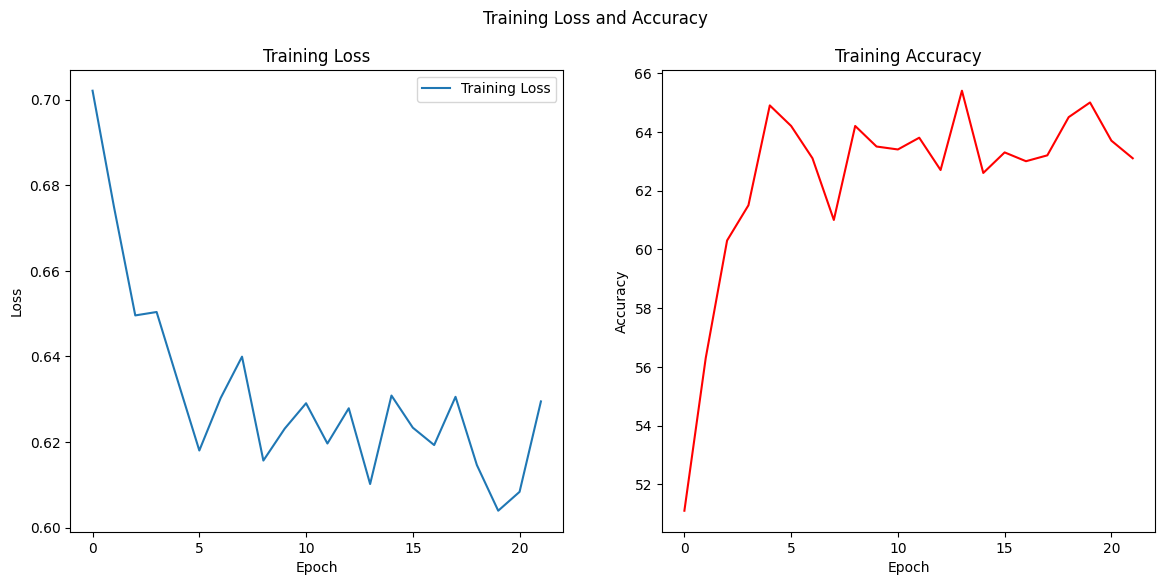

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Training Loss and Accuracy')

ax1.plot( total_loss_epoch, label='Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')
ax1.legend()

ax2.plot(total_accuracy_epoch,color='red', label='Training Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training Accuracy')

plt.show()

For simple LR, maximum training accuracy is 65% and maximum testing accuracy is 72.6%.

In [77]:
total_loss_epoch = []
total_accuracy_epoch= []

def training_model(train_dataloader, epochs, lr):

  jet_gcn.train()

  #[0] becuase lr is a list
  if lr=="step":
    optimizer=torch.optim.Adam(jet_gcn.parameters(), lr=lr_step[0])
  elif lr=="exp":
    optimizer=torch.optim.Adam(jet_gcn.parameters(), lr=lr_exp[0])
  elif lr=="cosine":
    optimizer=torch.optim.Adam(jet_gcn.parameters(), lr=lr_cosine_annealing[0])
  else:
    optimizer=torch.optim.Adam(jet_gcn.parameters(), lr=lr)

  for epoch in range(epochs):
    total_loss=0
    correct_predictions=0
    total_predictions=0

    for data in train_dataloader:

      data = data.to(device)
      optimizer.zero_grad()

      num_nodes = data.x.size(0) #Numner of nodes in a batch

      data.edge_index = data.edge_index.clamp(0, num_nodes - 1)

      output = model(data.x, data.edge_index, data.batch)

      loss = criterion(output, data.y.squeeze())

      loss.backward()
      total_loss += loss.item()

      _, predicted = output.max(dim=1)
      correct_predictions += (predicted == data.y.squeeze()).sum().item()
      total_predictions += data.y.size(0)

      optimizer.step()

    accuracy_app = correct_predictions / total_predictions * 100
    loss_app= total_loss/len(train_dataloader)

    total_loss_epoch.append(loss_app)
    total_accuracy_epoch.append(accuracy_app)

    print(f"Epoch {epoch+1}, Loss: {loss_app}, Accuracy: {accuracy_app:.2f}%")

In [78]:
total_loss_epoch_eval = []
total_accuracy_epoch_eval = []

def testing_model_1(test_dataloader, lr):

  jet_gcn.eval()

  # Set optimizer based on lr type
  if lr == "step":
    optimizer = torch.optim.Adam(jet_gcn.parameters(), lr=lr_step[0])
  elif lr == "exp":
    optimizer = torch.optim.Adam(jet_gcn.parameters(), lr=lr_exp[0])
  elif lr == "cosine":
    optimizer = torch.optim.Adam(jet_gcn.parameters(), lr=lr_cosine_annealing[0])
  else:
    optimizer = torch.optim.Adam(jet_gcn.parameters(), lr=lr)

  total_loss = 0
  correct_predictions = 0
  total_predictions = 0

  with torch.no_grad():  # No gradients needed during evaluation
    for data in test_dataloader:
      data = data.to(device)

      num_nodes = data.x.size(0)  # Number of nodes in the batch

      data.edge_index = data.edge_index.clamp(0, num_nodes - 1)

      output = model(data.x, data.edge_index, data.batch)

      loss = criterion(output, data.y.squeeze())

      total_loss += loss.item()

      _, predicted = output.max(dim=1)
      correct_predictions += (predicted == data.y.squeeze()).sum().item()
      total_predictions += data.y.size(0)

  accuracy_eval = correct_predictions / total_predictions * 100
  loss_eval = total_loss / len(test_dataloader)  # Use test_dataloader length

  total_loss_epoch_eval.append(loss_eval)
  total_accuracy_epoch_eval.append(accuracy_eval)

  print(f"Loss: {loss_eval}, Accuracy: {accuracy_eval:.2f}%")


## II) Step LR

Epoch 1, Loss: 0.5978727893829345, Accuracy: 64.80%
Epoch 2, Loss: 0.6131480798721314, Accuracy: 62.60%
Epoch 3, Loss: 0.5891402196884156, Accuracy: 67.60%
Epoch 4, Loss: 0.5755351102352142, Accuracy: 67.60%
Epoch 5, Loss: 0.6092837376594543, Accuracy: 62.80%


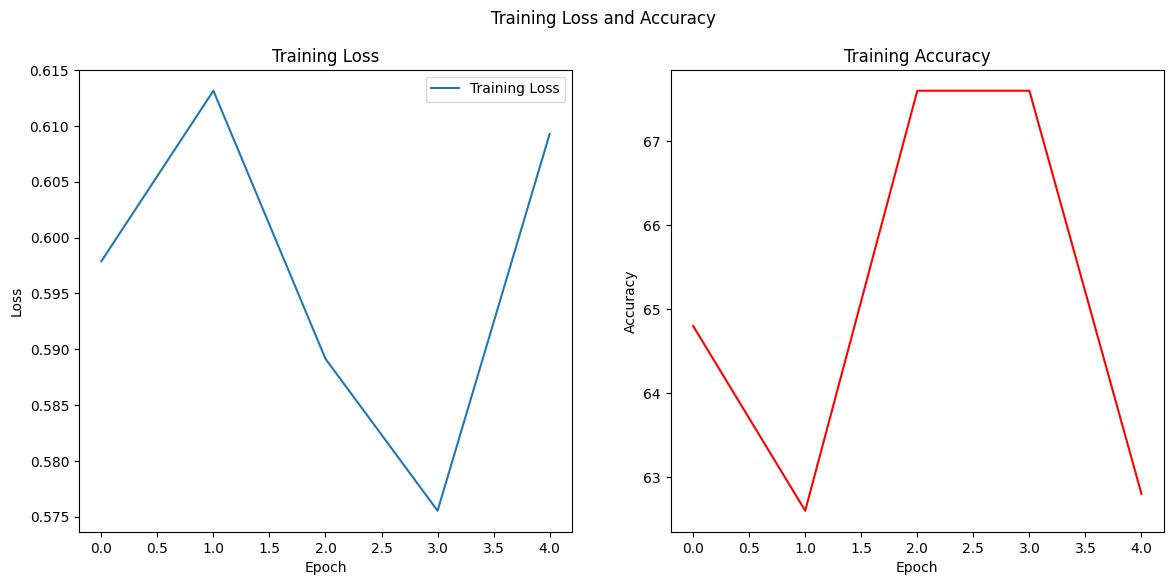

In [79]:
training_model(train_dataloader, epochs, lr="step")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Training Loss and Accuracy')

ax1.plot( total_loss_epoch, label='Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')
ax1.legend()

ax2.plot(total_accuracy_epoch,color='red', label='Training Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training Accuracy')

plt.show()


In [81]:
testing_model_1(test_dataloader,"step")

Loss: 0.5509620956182479, Accuracy: 77.00%


For step LR, maximum training and testing accuracies are 67.6% and 77%, respectively.

## III) Exponential LR

Epoch 1, Loss: 0.5925415610074997, Accuracy: 67.20%
Epoch 2, Loss: 0.567058897614479, Accuracy: 70.60%
Epoch 3, Loss: 0.5785577635765076, Accuracy: 69.40%
Epoch 4, Loss: 0.5891872700452805, Accuracy: 67.20%
Epoch 5, Loss: 0.5747474899291992, Accuracy: 67.40%


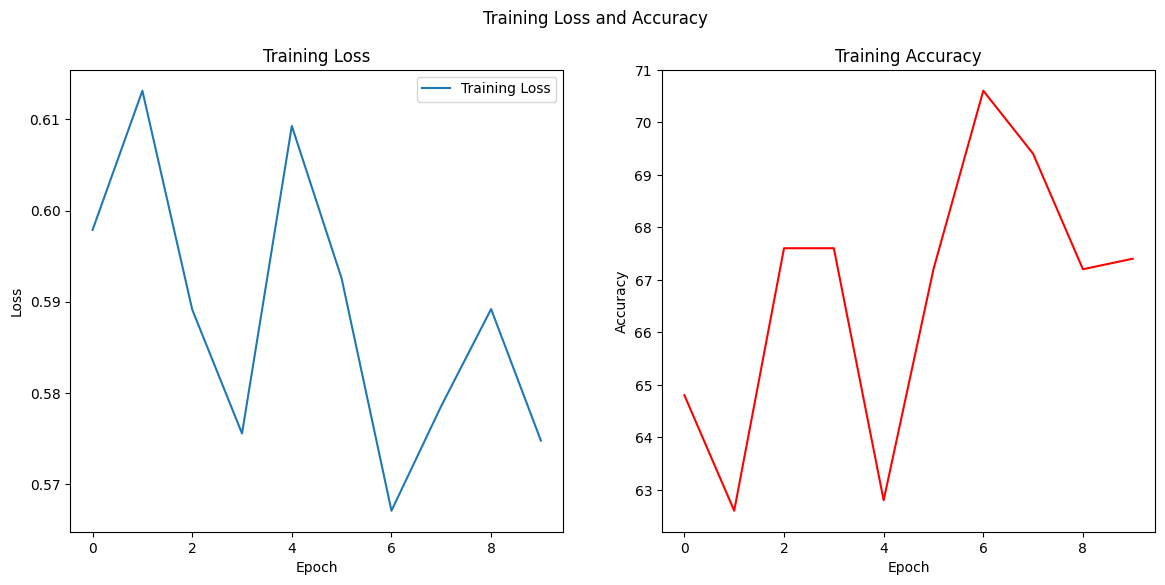

In [82]:
training_model(train_dataloader, epochs, lr="exp")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Training Loss and Accuracy')

ax1.plot( total_loss_epoch, label='Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')
ax1.legend()

ax2.plot(total_accuracy_epoch,color='red', label='Training Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training Accuracy')

plt.show()

In [83]:
testing_model_1(test_dataloader,"exp")

Loss: 0.5461730189323425, Accuracy: 77.00%


For exponenial LR, maximum training and testing accuracies are 70.6% and 77% , respectively.

## IV) Cosine Annealing LR

Epoch 1, Loss: 0.5995532443523407, Accuracy: 64.40%
Epoch 2, Loss: 0.5836963076591491, Accuracy: 65.80%
Epoch 3, Loss: 0.5713766720294953, Accuracy: 69.20%
Epoch 4, Loss: 0.5756294090747833, Accuracy: 66.80%
Epoch 5, Loss: 0.5608502141237259, Accuracy: 67.20%


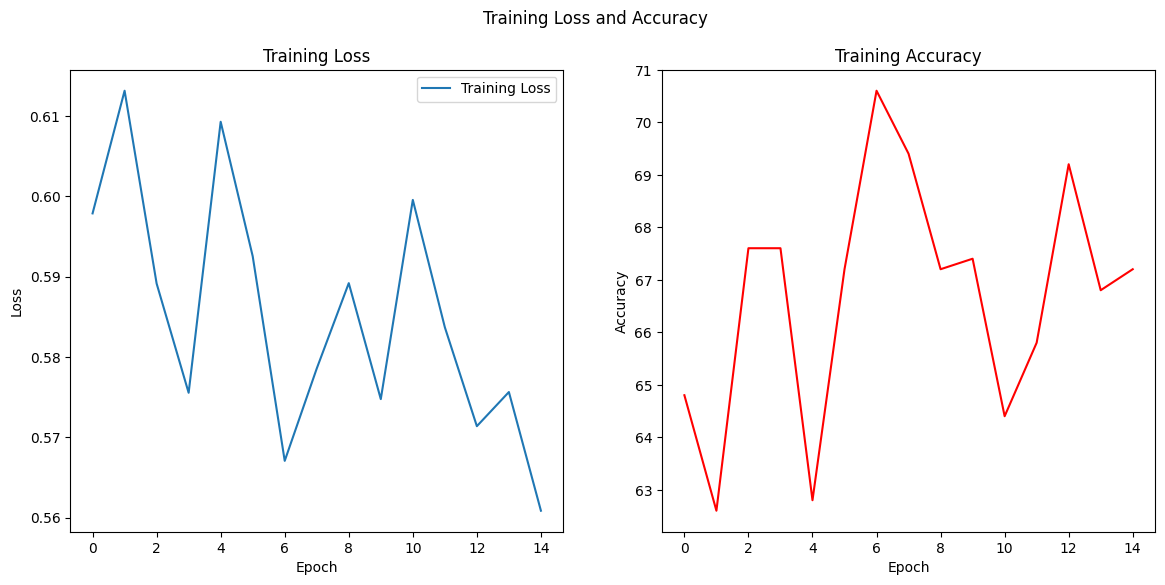

In [84]:
training_model(train_dataloader, epochs, lr="cosine")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Training Loss and Accuracy')

ax1.plot( total_loss_epoch, label='Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')
ax1.legend()

ax2.plot(total_accuracy_epoch,color='red', label='Training Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training Accuracy')

plt.show()


In [85]:
testing_model_1(test_dataloader,"cosine")

Loss: 0.5395266530513764, Accuracy: 77.40%


For cosine annealing, maximum training and testing accuracies are 69.2% and 77.4% ,respectively.

# **5. Graph Attention Network (GNN Architecture 2)**

In [113]:
#Model class

class JetGAT(nn.Module):
    def __init__(self, in_features, hidden_dim, num_classes, num_heads=4, dropout=0.3):
        super(JetGAT, self).__init__()

        self.gat1 = GATConv(in_features, hidden_dim, heads=num_heads, dropout=dropout)
        self.bn1 = BatchNorm(hidden_dim * num_heads)
        self.gat2 = GATConv(hidden_dim * num_heads, hidden_dim * 2, heads=num_heads, dropout=dropout)
        self.bn2 = BatchNorm(hidden_dim * 2 * num_heads)
        self.gat3 = GATConv(hidden_dim * 2 * num_heads, num_classes, heads=1, dropout=dropout)

        # Pooling layer --> Aggregates node features to jet-level features
        self.pool = global_mean_pool

        self.fc = nn.Linear(num_classes, num_classes)
        self.dropout = dropout

        self.reset_parameters()

    def reset_parameters(self):
        """Xavier Initialization"""
        for layer in [self.gat1, self.gat2, self.gat3]:
            torch.nn.init.xavier_uniform_(layer.lin.weight)
        torch.nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x, edge_index, batch):
        x = self.gat1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.gat2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)

        x = self.gat3(x, edge_index)
        x = F.relu(x)

        x = self.pool(x, batch)

        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.fc(x)

        return F.log_softmax(x, dim=1)




In [114]:
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
jet_gat= JetGAT(in_features= 4, hidden_dim= 256, num_classes=2).to(device)
model= jet_gat

epochs = 5
lr=1e-5
optimizer = torch.optim.Adam(jet_gat.parameters(), lr = 1e-5)
criterion = torch.nn.CrossEntropyLoss()

In [115]:
total_loss_epoch_gat = []
total_accuracy_epoch_gat= []

def training_model_gat(train_dataloader, epochs):

  jet_gat.train()

  for epoch in range(epochs):
    total_loss=0
    correct_predictions=0
    total_predictions=0

    for data in train_dataloader:

      data = data.to(device)
      optimizer.zero_grad()

      num_nodes = data.x.size(0)

      data.edge_index = data.edge_index.clamp(0, num_nodes - 1)

      output = model(data.x, data.edge_index, data.batch)

      loss = criterion(output, data.y.squeeze())

      loss.backward()
      total_loss += loss.item()

      _, predicted = output.max(dim=1)
      correct_predictions += (predicted == data.y.squeeze()).sum().item()
      total_predictions += data.y.size(0)

      optimizer.step()

    accuracy_gat = correct_predictions / total_predictions * 100
    loss_gat= total_loss/len(train_dataloader)

    total_loss_epoch_gat.append(loss_gat)
    total_accuracy_epoch_gat.append(accuracy_gat)

    print(f"Epoch {epoch+1}, Loss: {loss_gat}, Accuracy: {accuracy_gat:.2f}%")

In [116]:
def testing_model_gatt(test_dataloader):
    jet_gat.eval()

    with torch.no_grad():
        correct_predictions = 0
        total_predictions = 0
        total_loss = 0

        for data in test_dataloader:
            data = data.to(device)

            num_nodes = data.x.size(0)

            data.edge_index = data.edge_index.clamp(0, num_nodes - 1)

            output = model(data.x, data.edge_index, data.batch)

            loss = criterion(output, data.y.squeeze())
            total_loss += loss.item()

            _, predicted = output.max(dim=1)
            correct_predictions += (predicted == data.y.squeeze()).sum().item()
            total_predictions += data.y.size(0)

        accuracy_eval_gat = correct_predictions / total_predictions * 100
        loss_eval_gat = total_loss / len(test_dataloader)

        print(f"Loss: {loss_eval_gat:.4f}, Accuracy: {accuracy_eval_gat:.2f}%")

In [117]:
training_model_gat(train_dataloader, epochs)

Epoch 1, Loss: 0.6986090633869171, Accuracy: 54.60%
Epoch 2, Loss: 0.6558812992572784, Accuracy: 60.60%
Epoch 3, Loss: 0.6308773112297058, Accuracy: 62.20%
Epoch 4, Loss: 0.6685294098854065, Accuracy: 61.60%
Epoch 5, Loss: 0.638420315027237, Accuracy: 62.40%


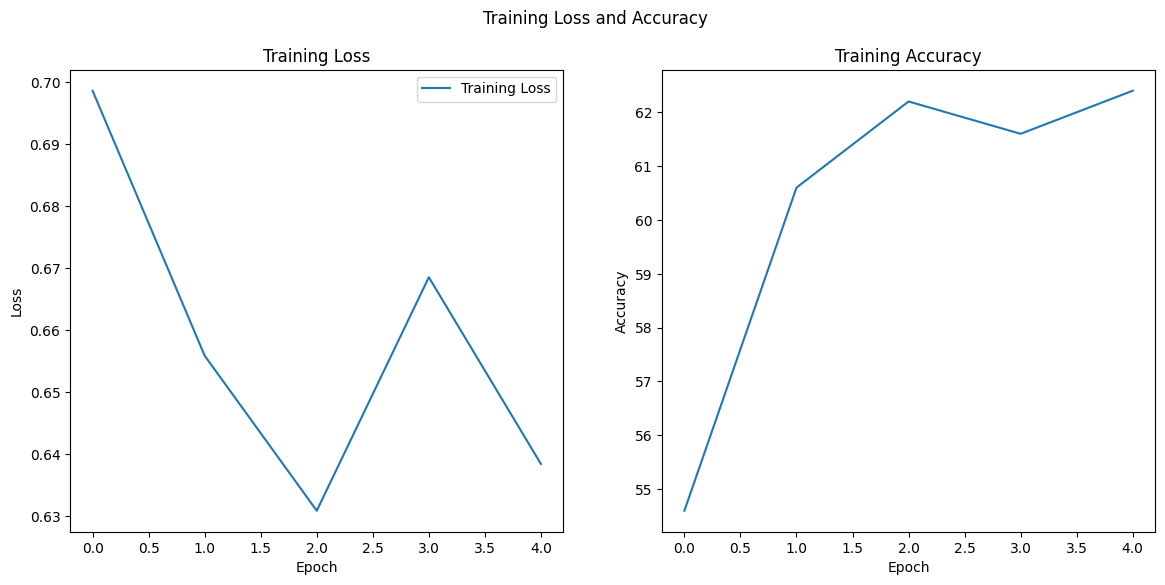

In [118]:
fig, (ax1,ax2)= plt.subplots(1,2, figsize=(14,6))
fig.suptitle('Training Loss and Accuracy')

ax1.plot(total_loss_epoch_gat, label='Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')
ax1.legend()

ax2.plot(total_accuracy_epoch_gat, label= 'Training Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training Accuracy')

plt.show()

In [119]:
testing_model_gatt(test_dataloader)

Loss: 0.6119, Accuracy: 70.60%


We got maximum training and testing accuracies of 62.4% and 70.6% with GATs by using simple LR.

Similarly, we can check with other lr schedulers as well, like we did for GCNs.